## Analysis and Quantification of Enamel STEM Images

Filtering and grain analysis using Moving Window Local Fourier Transform

In [1]:
#Dependencies
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


import hyperspy.api as hs
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
hs.preferences.GUIs.warn_if_guis_are_missing = False
hs.preferences.save()

import skimage
from skimage import filters
from skimage.morphology import disk
from skimage.feature import blob_log

#for scalebar
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm


In [2]:
filename = 'images/10_1.3Mx_1x1us_4096px_mono100_0.05nAscreeni_50umC2_1.ser'

import ncempy.io as nio
with nio.ser.fileSER(filename) as ser1:
    stem_image, metadata = ser1.getDataset(0)


In [5]:
calibration = metadata['Calibration'][0]['CalibrationDelta']
barsize = 10e-09/calibration
barsize

539.4307883999762

In [6]:
# Normalizing image here:
stem_image = skimage.img_as_float(stem_image)

# Filtering
stem_filtered = filters.median(stem_image, disk(5))


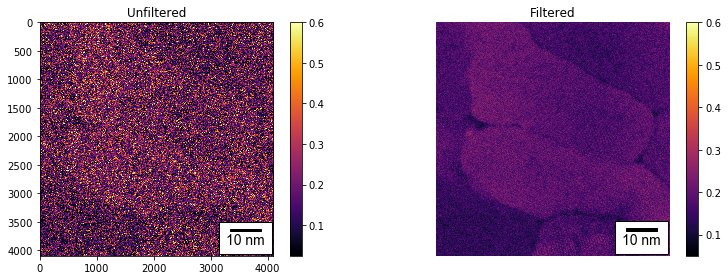

In [7]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
fontprops = fm.FontProperties(size=14, family='Arial') #for scale bar


im_handle = axes[0].imshow(stem_image, cmap='inferno', vmax = 0.6)
axes[0].set_title('Unfiltered')
# axes[0].axis('off')

#Adding Scale Bar
scalebar = AnchoredSizeBar(axes[0].transData,
                           barsize, '10 nm', 'lower right', 
                           pad=0.5,
                           color='black',frameon=True,
                           size_vertical=50,
                           fontproperties=fontprops)

axes[0].add_artist(scalebar)


# Adding a colorbar:
cbar = plt.colorbar(im_handle, ax=axes[0], orientation='vertical',
fraction=0.046, pad=0.04, use_gridspec=True)

im_handle = axes[1].imshow(stem_filtered, cmap='inferno', vmax = 0.6)
axes[1].set_title('Filtered')
axes[1].axis('off')

#Adding Scale Bar
scalebar = AnchoredSizeBar(axes[0].transData,
                           barsize, '10 nm', 'lower right', sep = 2.5,
                           pad=0.5,color='black',frameon=True,
                           size_vertical=50,
                           fontproperties=fontprops)

axes[1].add_artist(scalebar)

# Adding a colorbar:
cbar = plt.colorbar(im_handle, ax=axes[1], orientation='vertical',
fraction=0.046, pad=0.04, use_gridspec=True)

fig.tight_layout()
plt.show()

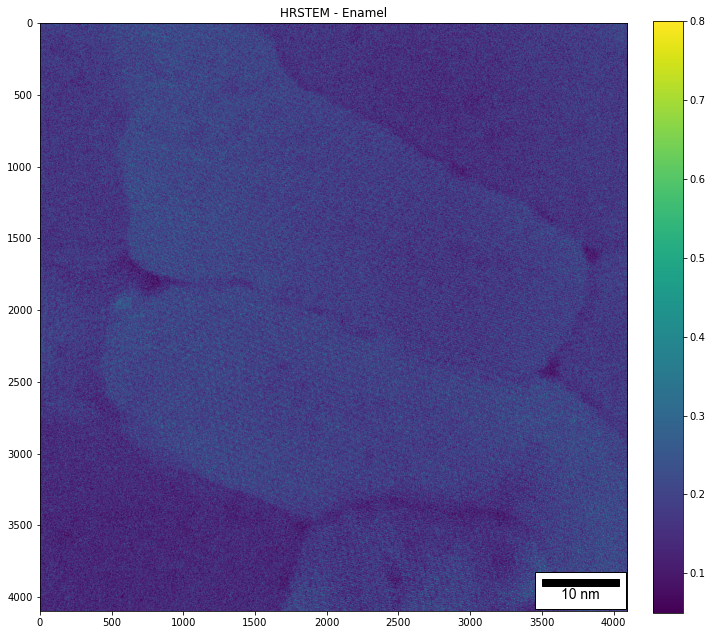

In [12]:
# Adding Inset in (b)
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

fig, ax = plt.subplots(ncols=1, figsize=(10, 10))
fontprops = fm.FontProperties(size=14, family='Arial') #for scale bar


im_handle = ax.imshow(stem_filtered, cmap='viridis', vmax = 0.8)
ax.set_title('HRSTEM - Enamel')
# ax.axis('off')

#Adding Scale Bar
scalebar = AnchoredSizeBar(ax.transData,
                           barsize, '10 nm', 'lower right', 
                           pad=0.5,
                           color='black',frameon=True,
                           size_vertical=50,
                           fontproperties=fontprops)

ax.add_artist(scalebar)


# Adding a colorbar:
cbar = plt.colorbar(im_handle, ax=ax, orientation='vertical',
fraction=0.046, pad=0.04, use_gridspec=True)



#FOR ZOOM INSET

# axins = zoomed_inset_axes(ax, 5, loc=1)  # zoom = 6
# axins.imshow(stem_filtered, interpolation="nearest",
#               origin="lower")


# # sub region of the original image
# x1, x2, y1, y2 = 2500, 3000, 2500, 3000
# axins.set_xlim(x1, x2)
# axins.set_ylim(y1, y2)

# # fix the number of ticks on the inset axes
# axins.yaxis.get_major_locator().set_params(nbins=7)
# axins.xaxis.get_major_locator().set_params(nbins=7)

# plt.setp(axins.get_xticklabels(), visible=False)
# plt.setp(axins.get_yticklabels(), visible=False)

# # draw a bbox of the region of the inset axes in the parent axes and
# # connecting lines between the bbox and the inset axes area
# mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")


fig.tight_layout()
plt.show()


**Moving Window Local Fourier Transform**

Divide image into parts of elementsize and move it in x and y direction by xstep and ystep

In [13]:
from numpy.lib.stride_tricks import as_strided


In [48]:
# Setting up parameters:

elementsize = 64 #128 default for ~2000x2000 pixels image
xstep = 32 #64 default for ~2000x2000 pixels image
ystep = 32 #64 default for ~2000x2000 pixels image
NComponents = "auto" #automatically determine number of components for NMF decomposition from PCA Scree Plot
#NComponents = 3 #specify number of components for NMF decomposition
ImageRescale = False # put True if you wish to rescale your image to 2048pixels width

# shape of the elements on which you want to perform the operation (e.g. Fourier Transform)
ws = np.arange(elementsize*elementsize).reshape(elementsize, elementsize)


In [49]:
imdata = np.copy(stem_filtered);

imdataW = as_strided(imdata,
                     shape=(int((imdata.shape[0]-ws.shape[0]+1)/xstep),int((imdata.shape[1]-ws.shape[1]+1)/ystep),ws.shape[0],ws.shape[1]),
                     strides=(imdata.strides[0]*xstep,imdata.strides[1]*ystep,imdata.strides[0],imdata.strides[1]))

In [50]:
imdataW.shape

(126, 126, 64, 64)

In [46]:
# imWindow = hs.signals.Signal2D(imdataW)
# imWindow.plot(cmap='plasma', axes_ticks=False, scalebar=False, axes_off=True) #plot divided image

In [51]:
hanningf = np.hanning(elementsize)
hanningWindow2d = np.sqrt(np.outer(hanningf, hanningf))

imdataWfft = np.fft.fftshift(np.abs(np.fft.fft2(hanningWindow2d*imdataW))**2, axes=(2,3))

In [120]:
# imdataWfft = imdataWfft+10000 #adding offset to prevent 0

In [21]:
imdataWfft = np.log(np.abs(imdataWfft))

In [22]:
imWindowFFT = hs.signals.Signal2D(imdataWfft)

Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


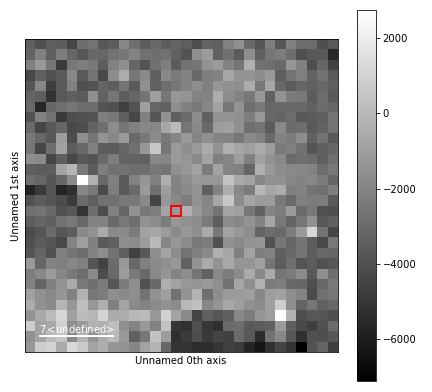

<IPython.core.display.Javascript object>


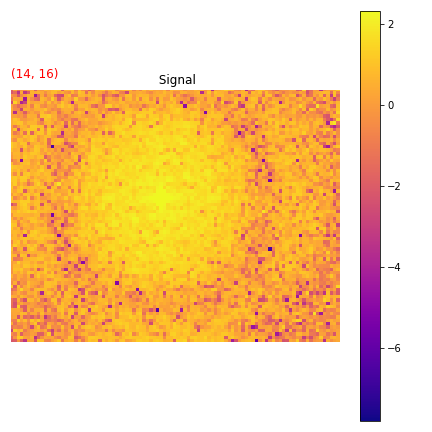

In [27]:
imWindowFFT.plot(cmap='plasma', axes_ticks=False, scalebar=False, axes_off=True) #plot 4D local FFT data

In [28]:
imWindowFFT.decomposition()

<IPython.core.display.Javascript object>


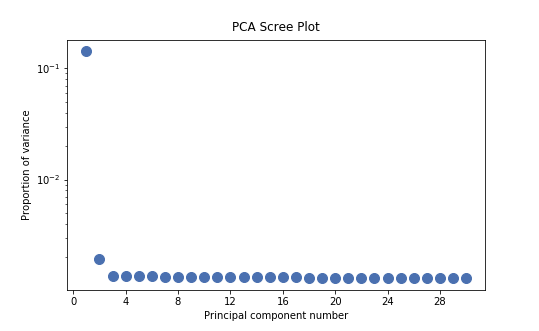

In [29]:
imWindowFFT.plot_explained_variance_ratio(n=30, xaxis_type='number') #plot PCA Scree Plot

In [30]:
screedata = imWindowFFT.get_explained_variance_ratio().data

In [31]:
grad = np.gradient(screedata)

In [32]:
gradS = hs.signals.Signal1D(grad)

In [33]:
# gradS.plot()

In [34]:
from scipy.signal import argrelextrema

In [35]:
gradLocalMaxima0 = argrelextrema(grad, np.greater)

In [36]:
gradLocalMaxima = [x + 1 for x in gradLocalMaxima0[0]] # add 1 due to the array indexing from 0

In [37]:
# print("Estimated candidates for number of components from PCA Scree Plot\n", gradLocalMaxima)

In [38]:
if NComponents == "auto":
    NComponents = gradLocalMaxima[0]

In [39]:
print("Taking", NComponents, "components for NMF Decomposition") #estimated number of components (first local maximum)

Taking 4 components for NMF Decomposition


<IPython.core.display.Javascript object>


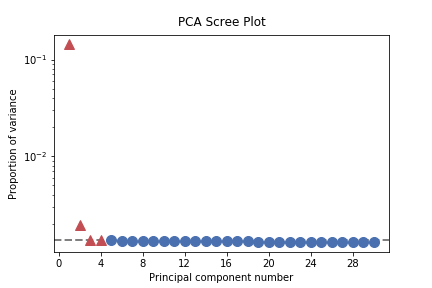

In [40]:
imWindowFFT.plot_explained_variance_ratio(n=30, xaxis_type='number', threshold=NComponents, hline=True) #plot PCA Scree Plot

In [41]:
## Perform Decomposition on the Local FFT data by NMF
### you have to provide number of components in output_dimension (e.g. from PCA Scree Plot)


In [42]:
imWindowFFT.decomposition(algorithm="nmf", output_dimension=NComponents)

ValueError: Negative values in data passed to NMF (input X)

In [144]:
#imWindowFFT.plot_decomposition_results()

In [146]:
#FFT Measurements (optional)
#distantace in lengths units = 1/(distance in FFT)*elementsize*scale [unit i.e nm]
# elementsize*im.axes_manager[0].scale # if properly calibration read from image file

In [147]:
### Plottings


In [148]:
## Loadings
loadingsS = imWindowFFT.get_decomposition_loadings()

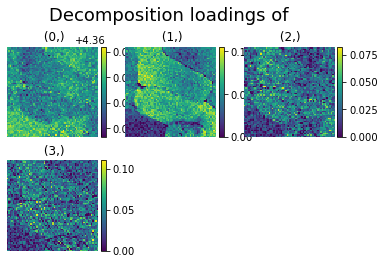

In [149]:
hs.plot.plot_images(loadingsS,cmap='viridis', scalebar=None, axes_decor='off')

In [ ]:
# Factors

In [150]:
factorsS =  imWindowFFT.get_decomposition_factors()

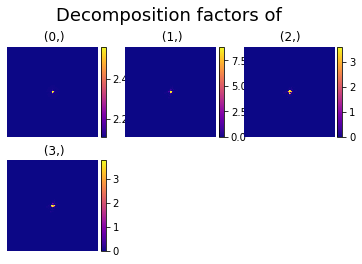

In [151]:
hs.plot.plot_images(factorsS,cmap='plasma', scalebar=None, axes_decor='off')